# Data Challenge 1
In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

##  Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers

## Hints
* What are the main factors that drive employee churn? Do they make sense? Explain your findings.
* What might you be able to do for the company to address employee Churn, what would be follow-up actions?
* If you could add to this data set just one variable that could help explain employee churn, what would that be?

Your output should be in the form of a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import pandas as pd
import datetime
import numpy as np
import scipy
import seaborn as sns, matplotlib
import pickle

In [4]:
mydateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_raw = pd.read_csv('employee_retention_data.csv', parse_dates=["join_date"], date_parser=mydateparser)
#df = pd.read_csv("employee_retention_data.csv")
df_raw

## Preparing Data for Analysis

In [5]:
employees = len(df_raw)

print (f" Data contains {employees} employees in {len(df_raw['company_id'].unique())} companies, and the following departemnts:\n{df_raw['dept'].unique()}")
       

 Data contains 24702 employees in 12 companies, and the following departemnts:
['customer_service' 'marketing' 'data_science' 'engineer' 'sales' 'design']


In [6]:
quited = df_raw['quit_date'].isnull().sum()
print (f"From all dataset {quited} number have quited, which is {quited/employees} of all")

From all dataset 11192 number have quited, which is 0.453080722208728 of all


### Separating nan into test set

In [117]:
df_test = df_raw[df_raw['quit_date'].isnull()]
df_train = df_raw[~df_raw['quit_date'].isnull()]

In [118]:
df_train['quit_date'] = pd.to_datetime(df_train['quit_date'])   #change quit_time also into datetime

/anaconda3/envs/labx/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
# Calculating the start date based on hours starting from 2011-01-01
df_train['start']= (df_train['join_date'] - pd.to_datetime("2011-01-01", format='%Y-%m-%d')).astype('timedelta64[h]')

/anaconda3/envs/labx/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# Changing departments into integers representing categories
df_train['dept_id'] = df_train['dept'].astype('category').cat.codes

/anaconda3/envs/labx/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
# Calculating the quit time from the base time of 2011-01-01 of work on hours
df_train['quit'] = (df_train['quit_date']- pd.to_datetime("2011-01-01", format='%Y-%m-%d')).astype('timedelta64[h]')

/anaconda3/envs/labx/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
df_train.head(10)

In [13]:
# The last step in preparing the model 
df_train = df_train.drop(['employee_id','dept', 'join_date', 'quit_date'], axis=1)

## Exploratory Data Analysis
First I looked into the distribution of the work duration in the training data set

[Text(0, 0.5, 'no. of employees'), Text(0.5, 0, 'Stay Duration (Days)')]

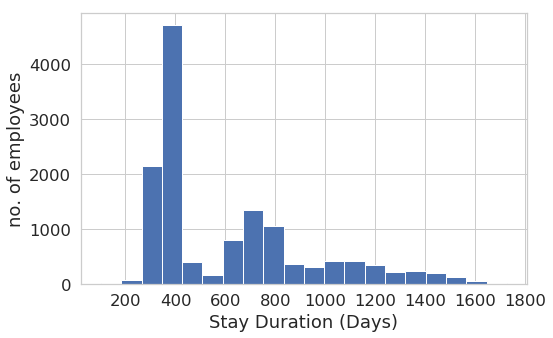

In [39]:
duration = pd.DataFrame({'duration':(df_train['quit'] - df_train['start'])/24}) #to recalibratie into days

sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 5]})
sns.distplot(duration['duration'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Stay Duration (Days)', ylabel='no. of employees')

A large portion of employees have left in one year after starting their job. Also looking into the startpoint may tell some thing.

[Text(0, 0.5, 'Start Date'), Text(0.5, 0, 'no. of employees who quit')]

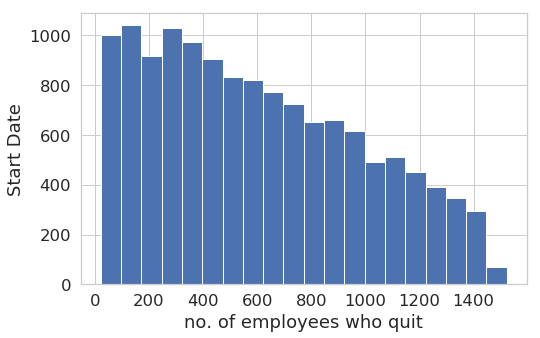

In [20]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 5]})
sns.distplot(df_train['start']/24, norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='no. of employees who quit', ylabel='Start Date')


The distribution makes sense. It shows that there is no specific constraint about the date of job start that might have caused the termination

## Creating the Model
The question I figured out to answer is, How long it takes for an employee to quit the job. For this purpose, I considered 'quit' as response variable and other columns as features:

In [35]:
df_train.columns

Index(['company_id', 'seniority', 'salary', 'start', 'dept_id', 'quit'], dtype='object')

In the follow, I have tested different linear models and considered MSE to compare their performance

In [37]:
# response variable : quit
# covariates : 'company_id', 'seniority', 'salary', 'start', 'dept_id'
# Creating a linear regression model

# Starting with Linear Regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Defining Kfolds
kfold = KFold(n_splits=10, random_state=7)
scoring = 'neg_mean_squared_error'

# Changing into covariates and response variables
all_array = df_train.values
X = all_array[:,0:4]
Y = all_array[:,5]

#### Here starting different models
def models(X, Y):
    model_1 = LinearRegression()
    results_lr = cross_val_score(model_1, X, Y, cv=kfold, scoring=scoring)
    print(f"MSE for Linear regression: {results_lr.mean()}")

    model_2 = Ridge()
    results_ridge = cross_val_score(model_2, X, Y, cv=kfold, scoring=scoring)
    print(f"MSE for Ridge regression: {results_ridge.mean()}")

    model_3 = Lasso()
    results_lasso = cross_val_score(model_3, X, Y, cv=kfold, scoring=scoring)
    print(f"MSE for lasso regression: {results_lasso.mean()}")

    model_4 = ElasticNet()
    results_en = cross_val_score(model_4, X, Y, cv=kfold, scoring=scoring)
    print(f"MSE for elastic net: {results_en.mean()}")

models(X, Y)

MSE for Linear regression: -50657047.2925086
MSE for Ridge regression: -50657047.210501306
MSE for lasso regression: -50656986.37538006
MSE for elastic net: -50656561.37671344


To explain: The resulted score is negative MSE scores, i.e. negate them and we get the MSE. The thing is that GridSearchCV, by convention, always tries to maximize its score so loss functions like MSE have to be negated.

The results don't show any meaningful difference between these different linear methods for a 10-fold cross validation

### Workaround
There is a very big difference in the magnitude and the range for different features, therefore it is a good practice to normalize data in each column of features

In [78]:
# Standardize data (0 mean, 1 stdev)
# Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 
# Mean and standard deviation are then stored to be used on later data using the transform method.
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
all_array = df_train.values
X = all_array[:,0:5]
Y = all_array[:,5]

scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
# summarize transformed data
#set_printoptions(precision=3)
#print(rescaledX[0:30,:])
models(rescaledX, Y )


MSE for Linear regression: -50560798.78413293
MSE for Ridge regression: -50560795.62042662
MSE for lasso regression: -50560809.76597783
MSE for elastic net: -54617951.95655833


# Second Thought - Logistic Regression
The second approach I considered is to predict if an employee is going to quit or not. Using this approach, I created a boolean column for quit or not, also replaced Nan values in quit_date column with 2015/12/13. Then modeled a logistic regression

In [74]:
mydateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_2 = pd.read_csv('employee_retention_data.csv', parse_dates=["join_date"], date_parser=mydateparser)

# Add the boolean column of quit into the dataframe, in such a way that if quit_date is Nan quit is False
# Changing departments into integers representing categories
# df_2['dept_id'] = df_2['dept'].astype('category').cat.codes


df_2.loc[df_raw['quit_date'].isnull(),'quit_date'] = '2015-12-13'  # Changing all Nan in quit_date into the latest
df_2['quit_date'] = pd.to_datetime(df_2['quit_date'])   #change quit_time also into datetime
df_2['join_date'] = pd.to_datetime(df_2['join_date'])

df_2['start']= (df_2['join_date'] - pd.to_datetime("2011-01-01", format='%Y-%m-%d')).astype('timedelta64[h]')
df_2['finish']= (df_2['quit_date'] - pd.to_datetime("2011-01-01", format='%Y-%m-%d')).astype('timedelta64[h]')

dummies = pd.get_dummies(df_2['dept']).rename(columns=lambda x: 'dept_' + str(x))
df_2 = pd.concat([df_2, dummies], axis=1)

dummies = pd.get_dummies(df_2['company_id']).rename(columns=lambda x: 'Company_' + str(x))
df_2 = pd.concat([df_2, dummies], axis=1)

df_2['quit'] = df_raw['quit_date'].isnull()

df_2 = df_2.drop(['employee_id','dept', 'join_date', 'quit_date', 'company_id'], axis=1)


In [76]:
df_2.head(5)

In [101]:
# Normalizing the first four features
X_scale = df_2.iloc[:,0:4].values

scaler = StandardScaler().fit(X_scale)
rescaledX = scaler.transform(X_scale)

# Getting the rest columns of the dataframe
rest_X = df_2.iloc[:,4:22].values
### Now Concatenate them into the X array
X = np.concatenate((rescaledX, rest_X), axis=1)
Y = df_2.iloc[:,22].values

In [112]:
# Now creating the Logistic Regression model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)
model = LogisticRegression()
results = cross_val_score(model, X, Y, cv=kfold)
#print("Accuracy: %.3f%% (%.3f%%)") % (results.mean()*100.0, results.std()*100.0)
print(f"Accuracy - mean:{results.mean()*100.0}, sd: {results.std()*100.0}")

/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Accuracy - mean:97.95562123875825, sd: 0.16331786371510318


/anaconda3/envs/labx/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
